## Something to look up from output

- [x] batch_size
    - `samples_per_gpu` in config: please refer to https://github.com/open-mmlab/mmsegmentation/blob/master/mmseg/datasets/builder.py#L78
- [x] load model from intermediate step

In [2]:
GPU_NUMBER = 4
DEVICE = 'cpu' if GPU_NUMBER < 0 else 'cuda:{}'.format(GPU_NUMBER)

In [3]:
classes = (
    'sky', 'tree', 'road', 'grass', 
    'water', 'bldg', 'mntn', 'fg obj'
)
palette = [
    [128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
    [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]
]

meta_dict = {"classes": classes, "palette": palette}

In [33]:
import torch, torchvision
import mmseg
import mmcv

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import glob
import numpy as np
from PIL import Image

from mmseg.models import build_segmentor
from mmseg.apis import init_segmentor, inference_segmentor

In [5]:
cfg = mmcv.Config.fromfile('../experiments/config_standfordbackground.py')

In [6]:
img_file = '../sample/demo.png'

## Note:

For default training demo, we didn't save PALETTE into meta data so we cannot directly use `init_segmentor`.

Therefore, we have to rewrite the function and prepare model properly.

In [7]:
def _prepare_model(config_, checkpoint_file=None, meta_dict={}, **kwargs):
    model = build_segmentor(config_.model, test_cfg=config_.get('test_cfg'))
    
    if checkpoint_file is not None:
        checkpoint = mmcv.runner.load_checkpoint(model, checkpoint_file, map_location='cpu')
        
    model.CLASSES = meta_dict.get("classes", ())
    model.PALETTE = meta_dict.get("palette", [])
    
    model.cfg = config_
    
    model.to(DEVICE)
    model.eval()
    
    return model

In [12]:
def _plot_results(raw_image, segmentor_results):
    img = mmcv.imread(raw_image)
    
    seg = segmentor_results[0]

    color_seg = np.zeros(img.shape, dtype=np.uint8)

    print("Color Segmentation Mask Shape: ", color_seg.shape)

    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # convert to BGR (it is required to convert segmentation mask to BGR to match raw image channel order)
    color_seg = color_seg[..., ::-1]

    # Overlay segmentation mask on to original image
    img_overlay = img * 0.5 + color_seg * 0.5
    img_overlay = img_overlay.astype(np.uint8)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    ax1.imshow(mmcv.bgr2rgb(img))
    ax2.imshow(mmcv.bgr2rgb(img_overlay))
    ax3.imshow(mmcv.bgr2rgb(color_seg))

    ax1.set_title("Raw Image")
    ax2.set_title("Overlay Prediction")

    

    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                              label=classes[i]) for i in range(8)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               fontsize='large')

    plt.show()

## Let's see predictions under different training steps.

Color Segmentation Mask Shape:  (512, 1024, 3)


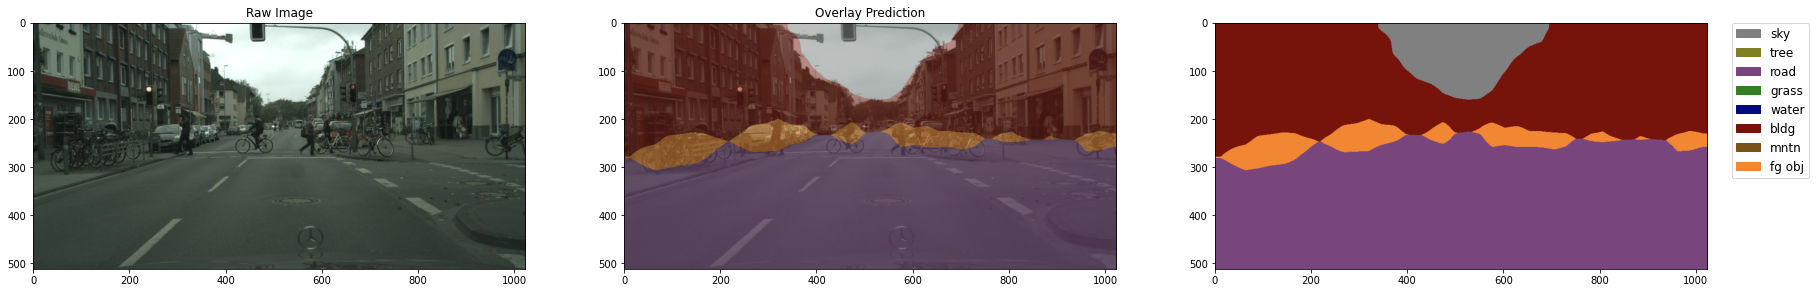

In [15]:
model = _prepare_model(cfg, '../work_dirs/tutorial_2/iter_25.pth', meta_dict)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


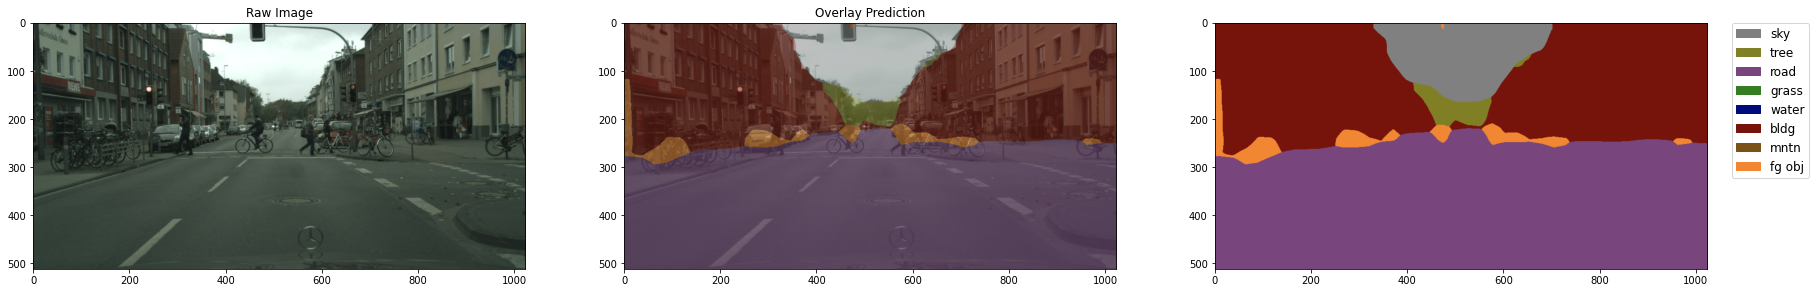

In [16]:
model = _prepare_model(cfg, '../work_dirs/tutorial_2/iter_50.pth', meta_dict)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


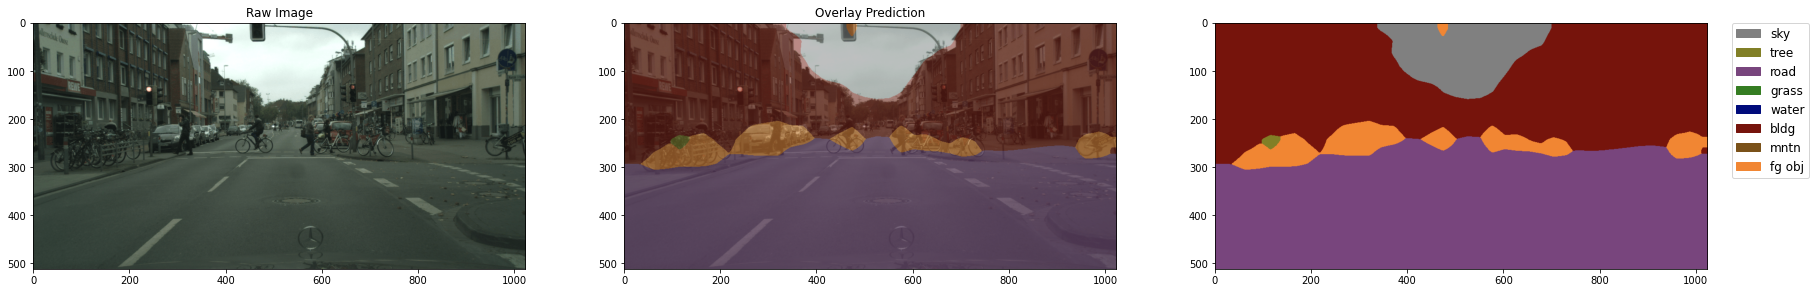

In [17]:
model = _prepare_model(cfg, '../work_dirs/tutorial_2/iter_75.pth', meta_dict)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


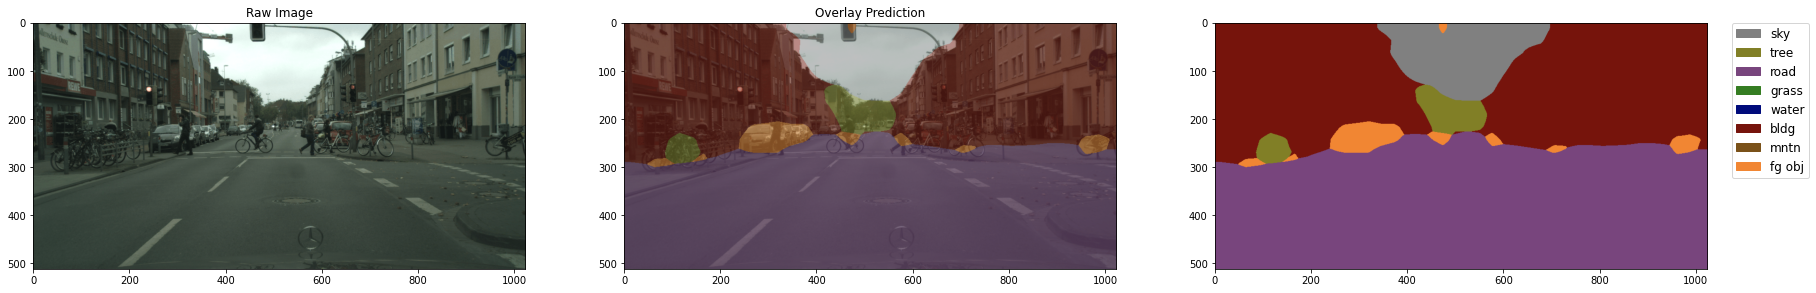

In [18]:
model = _prepare_model(cfg, '../work_dirs/tutorial_2/iter_100.pth', meta_dict)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

## Load checkpoints

Here we add meta data into checkpoints. So we can just directly `init_segmentor` function without modify it.

In [30]:
checkpts_ = torch.load("../work_dirs/debug_v1.0.0/iter_25.pth", map_location=torch.device("cpu"))

In [31]:
checkpts_["meta"]

{'iter': 25,
 'epoch': 1,
 'CLASSES': ('sky',
  'tree',
  'road',
  'grass',
  'water',
  'bldg',
  'mntn',
  'fg obj'),
 'PALETTE': [[128, 128, 128],
  [129, 127, 38],
  [120, 69, 125],
  [53, 125, 34],
  [0, 11, 123],
  [118, 20, 12],
  [122, 81, 25],
  [241, 134, 51]],
 'mmcv_version': '1.2.6',
 'time': 'Mon Feb 15 17:14:21 2021'}

Color Segmentation Mask Shape:  (512, 1024, 3)


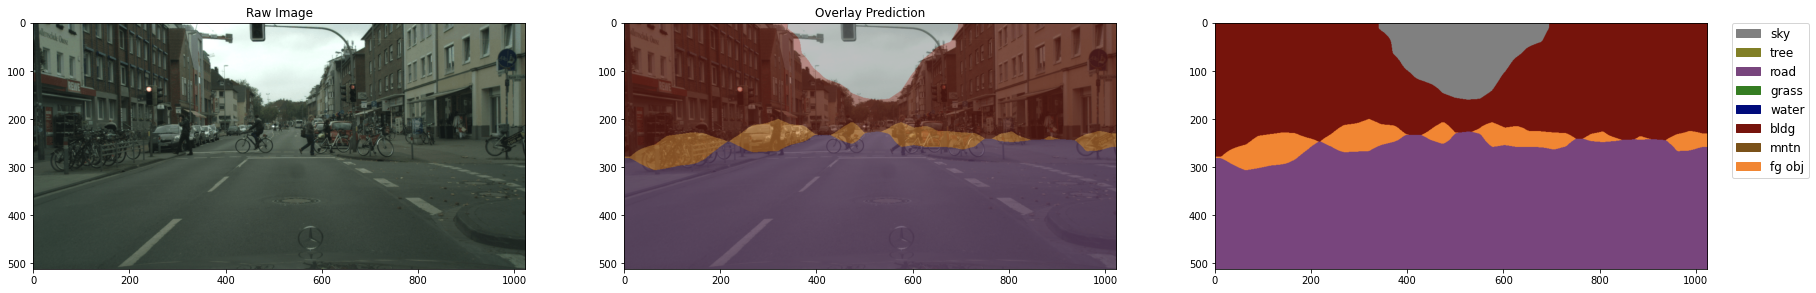

In [39]:
cfg = mmcv.Config.fromfile('../experiments/config_standfordbackground_v1.0.0.py')
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_25.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


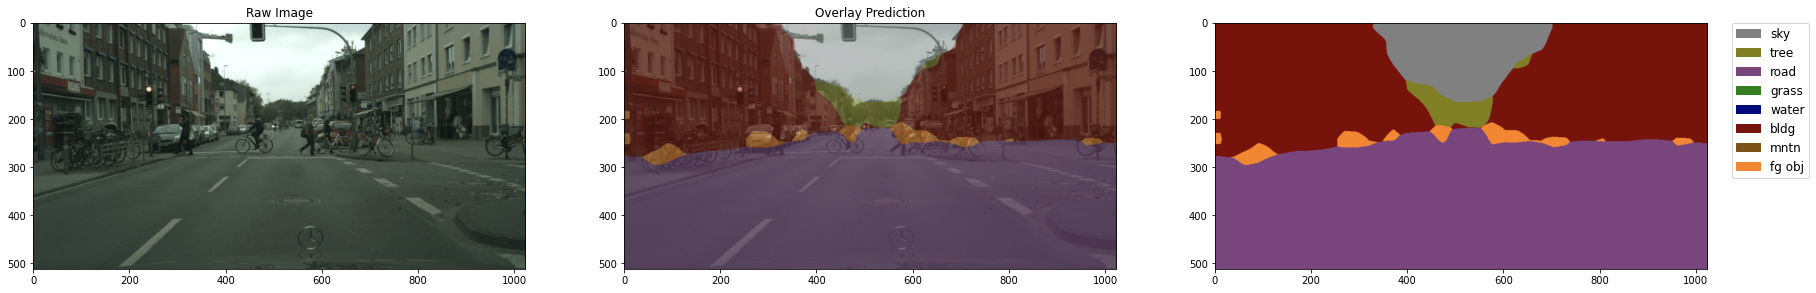

In [40]:
cfg = mmcv.Config.fromfile('../experiments/config_standfordbackground_v1.0.0.py')
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_50.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

In [ ]:
|